In [87]:
# pip install pyspark
!pip install pandas scikit-learn numpy

In [88]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt 
import seaborn as sns

## 1- Read the processed datasets

In [89]:

file_path1 = "/kaggle/input/dataset-fully-processed-jobs/final_output_processed_70k.csv"
file_path2 = "/kaggle/input/dataset-fully-processed-jobs/final_output_processed_33k.csv"

# Read the first CSV file into a Pandas DataFrame
df1 = pd.read_csv(file_path1)
df1 = df1[df1['orgTags_SKILLS'] != 'NOT FOUND']  # Remove rows where 'orgTags_SKILLS' is 'NOT FOUND'

# Read the second CSV file into another Pandas DataFrame
df2 = pd.read_csv(file_path2)
df2 = df2[df2['orgTags_SKILLS'] != 'NOT FOUND']  # Remove rows where 'orgTags_SKILLS' is 'NOT FOUND'

# Concatenate the two DataFrames into a single DataFrame
df_jobs = pd.concat([df1, df2], ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df_jobs.head())


                         id sourceCC            source locale  \
0  6137b0bb7d4ffc16c87fb191       us  careerbuilder_us  en_US   
1  6137b1357d4ffc16c87fb70b       us  careerbuilder_us  en_US   
2  6137b21d7d4ffc16c87fc35b       us  careerbuilder_us  en_US   
3  6137b9427d4ffc16c87ff894       us  careerbuilder_us  en_US   
4  6137ba687d4ffc16c87ffdc6       us  careerbuilder_us  en_US   

                                       position_name position_workType  \
0                       Loan Processor - Direct Hire          FULLTIME   
1                              Senior R&D Specialist          FULLTIME   
2  Client Service Manager - Digital Marketing - T...          FULLTIME   
3                                    Assembly Worker          FULLTIME   
4                                   Business Analyst        CONTRACTOR   

  position_careerLevel position_department orgAddress_addressLine  \
0            NOT FOUND           NOT FOUND              NOT FOUND   
1               SENIOR    

## 2- Read the resume dataset and process the required filled by extracting the skills

In [90]:
df_resume = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')
df_resume.head(2)


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR


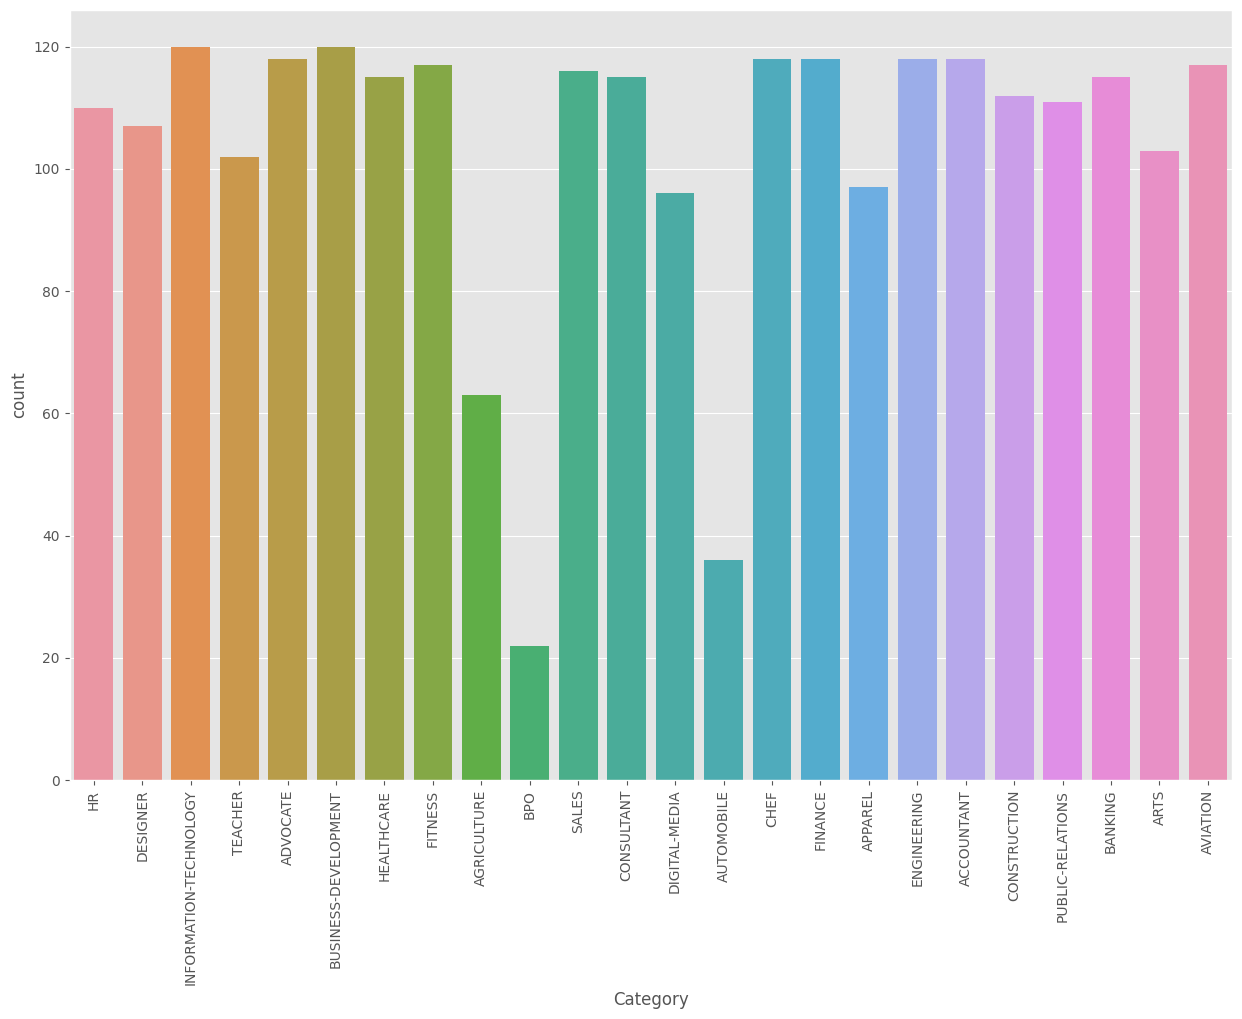

In [91]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
sns.countplot(x=df_resume['Category'])
plt.xticks(rotation=90)
plt.show()

In [92]:
print(df_resume['Resume_str'][0])

         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-tasker  Client relations specialist           Accomplishments      Missouri DOT Supervisor Training Certification  Certified by IHG in Customer Loyalty and Marketing by Segment   Hilton Worldwide General Manager Training Certification  Accomplished Trainer for cross server hospitality systems such as    Hilton OnQ  ,   Micros    Opera PMS   , Fidelio    OPERA    Reservation System (ORS) ,   Holidex    Completed courses and seminars in customer service, sales strategies, inventory control, loss preve

## Resume skills extraction
- Note: For all resume the skills section are always in the end
- Extract from every resume type a list of skills

In [93]:
import re

def extract_skills(resume_text):
    # Find all occurrences of the "Skills" section using regex with case insensitivity
    matches = re.findall(r'Skills\s+([\w\s,]+)\s*', resume_text, re.IGNORECASE)

    if matches:
        # Get the last match for the "Skills" section
        skills_text = matches[-1]
        # Split the skills text by commas or spaces to extract individual skills
        skills_list = [skill.strip() for skill in re.split(r',', skills_text)]
        return skills_list
    else:
        return []

# Apply the extract_skills function to the 'Resume_str' column and create a new 'skills' column
df_resume['skills'] = df_resume['Resume_str'].apply(extract_skills)
# Remove rows with empty skills or having only one item in the skills array
df_resume = df_resume[df_resume['skills'].apply(lambda x: len(x) > 1)]
print(df_resume.head())
# Save the DataFrame to a CSV file
# df_resume.to_csv('resume_data_with_skills.csv', index=False)


         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
4  17812897           HR MANAGER         Skill Highlights  ...   
5  11592605           HR GENERALIST       Summary     Dedic...   

                                         Resume_html Category  \
0  <div class="fontsize fontface vmargins hmargin...       HR   
1  <div class="fontsize fontface vmargins hmargin...       HR   
2  <div class="fontsize fontface vmargins hmargin...       HR   
4  <div class="fontsize fontface vmargins hmargin...       HR   
5  <div class="fontsize fontface vmargins hmargin...       HR   

                                              skills  
0  [Accounting, ads, advertising, analytical skil...  
1  [Adobe Photoshop, ADP, Asset Management, brand...  
2  [Desktop Publishing, Newsletter productions,

In [94]:
# from IPython.display import FileLink
# FileLink(r'resume_data_with_skills.csv')

## Create a new dataframe having only 1 resume from each category

In [95]:
import pandas as pd

# Initialize an empty list to store selected rows
selected_rows = []

# Define the number of rows per category
rows_per_category = 1

# Initialize a counter for rows added per category
rows_added = {}

# Iterate over the rows in the DataFrame
for index, row in df_resume.iterrows():
    category = row['Category']
    if category not in rows_added:
        rows_added[category] = 1
    else:
        rows_added[category] += 1
    
    # Check if the category has reached the desired number of rows
    if rows_added[category] <= rows_per_category:
        selected_rows.append(row)

# Create a new DataFrame from the selected rows list
df_selected_rows_resume = pd.DataFrame(selected_rows)

# Display the new DataFrame with three rows from each category
print(df_selected_rows_resume)


            ID                                         Resume_str  \
0     16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
112   76010167           DESIGNER       Summary     To get a s...   
218   21780877           INFORMATION TECHNOLOGY SPECIALIST\tGS...   
337   12467531           TEACHER         Professional Summary ...   
439   14445309           ADVOCATE         Professional Summary...   
559   13080868           BUSINESS DEVELOPMENT       Profession...   
677   23617240           HEALTHCARE           Executive Profil...   
794   10268614           FITNESS ATTENDANT           Summary  ...   
909   54246169           AGRICULTURE ADVISOR AND LANGUAGE OFFI...   
972   79261033           DIRECTOR OF OPERATIONS, BPO       Exe...   
994   87118391           SALES           Summary     Account M...   
1110  27096471           CONSULTANT       Summary      Human R...   
1225  13837784           DIGITAL MEDIA BUYER         Professio...   
1322  16332293           AUTOMOBIL

## TF-IDF with Cosine Similarity

In [110]:
def find_similar_jobs(job_skills, df_jobs, k=5):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_jobs['orgTags_SKILLS'])

    job_skills_tfidf = tfidf_vectorizer.transform(job_skills)

    # Calculate cosine similarity between job skills and resumes
    similarity_scores = cosine_similarity(job_skills_tfidf, tfidf_matrix)
    similar_indices = similarity_scores.argsort(axis=1)[:, -5:][:, ::-1]  # Get top 5 most similar
    similar_jobs = df_jobs.iloc[similar_indices.ravel()]
    return similar_jobs[['position_name']]

job_skills = ['SQL', 'data analytics']
find_similar_jobs(job_skills, df_jobs)


,position_name
4473,Front End Applications Developer
52827,Senior SQL Developer
33863,Senior SQL DBA
65383,C#/SQL Developer
37968,Data Warehouse Developer
65508,Data Analyst for Marketing Performance & Desig...
57520,Project Manager - Data Analytics Data Integration
24434,Business Data Analyst
20469,Delivery Manager
38242,Data Analyst


## Extending new Feature which the position name

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 

def find_similar_jobs(job_skills, df_jobs, k=5):
    # Initialize TF-IDF Vectorizer for both primary and additional features
    tfidf_vectorizer = TfidfVectorizer()
    combined_matrix = tfidf_vectorizer.fit_transform(
        df_jobs['orgTags_SKILLS'] + ' ' + df_jobs['position_name']
    )

    job_skills_tfidf = tfidf_vectorizer.transform(job_skills)

    # Calculate cosine similarity between job skills and combined features
    similarity_scores = cosine_similarity(job_skills_tfidf, combined_matrix)
    similar_indices = similarity_scores.argsort(axis=1)[:, -k:][:, ::-1]  # Get top k most similar
    similar_jobs = df_jobs.iloc[similar_indices.ravel()]
    return similar_jobs[['position_name']]

# Example usage
job_skills = ['SQL', 'data analytics']
find_similar_jobs(job_skills, df_jobs)


,position_name
53003,SQL Developer
65383,C#/SQL Developer
52827,Senior SQL Developer
28210,SQL Developer
56410,SQL Developer
2629,Data Analytics
24553,Data Engineer Analytics
53126,Data Analytics
551,Senior Data Analyst - (Digital Analytics/Web A...
57520,Project Manager - Data Analytics Data Integration


In [99]:
def find_similar_jobs(job_skills, df_jobs, k=5):

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_jobs['orgTags_SKILLS'])

    job_skills_tfidf = tfidf_vectorizer.transform(job_skills)
    nn_model = NearestNeighbors(n_neighbors=k, metric='cosine')

    # Fit the Nearest Neighbors model on the TF-IDF matrix
    nn_model.fit(tfidf_matrix)
    distances, indices = nn_model.kneighbors(job_skills_tfidf)

    # Extract most similar jobs name and their similarity scores
    similar_jobs = df_jobs.iloc[indices.ravel()]
    similar_scores = 1 - distances.ravel()  # Convert distances to similarity scores (1 - distance)

    # Create a DataFrame to display the results
    results_df = pd.DataFrame({
        'position_name': similar_jobs['position_name'],
        'similarity_score': similar_scores
    })

    # Sort the results DataFrame by similarity score in descending order
    results_df = results_df.sort_values(by='similarity_score', ascending=False)

    return results_df

# Iterate through all skills in df_resume
for index, row in df_selected_rows_resume.iterrows():
    # Print the category of the resume
    print("Category:", row['Category'])
    
    results = find_similar_jobs(row['skills'], df_jobs)
    
    # Print the results
    print(results)
    print()  # Empty line for readability


Category: HR
                                      position_name  similarity_score
50242                              Purchasing Agent               1.0
46913                              Purchasing Agent               1.0
26327                                Office Manager               1.0
55513                          Senior AR Accountant               1.0
23073                         HR/Payroll Specialist               1.0
...                                             ...               ...
43669                             Production Worker               0.0
43673                                 QC Specialist               0.0
43675                               Warehouse Clerk               0.0
43671                        Registered Nurse - ICU               0.0
43674  Sales / Marketing / Communications Associate               0.0

[180 rows x 2 columns]

Category: DESIGNER
                                      position_name  similarity_score
63413                            